# Intro to filtering and time-series processing

[scipy ref page](https://docs.scipy.org/doc/scipy/reference/signal.html)

## Topics - 
* basic demo of lp, hp, bp filters implenmented in time and freq domains. 
* wavelet transforms
* peak finding using wv transforms
[link here](https://plot.ly/python/fft-filters/)

[link pdf](file:///C:/Users/jserences/Downloads/Lecture_06_FIR_IIR_filters.pdf)

[link pdf](file:///C:/Users/jserences/Downloads/Lecture_07_Statistical_filtering.pdf)


## linear filters
* 
* Multiply FFT of timeseries by a transfer function, which is the FFT of time domain implementation of the filter
* A low-pass filter in the freq domain is a square wave that has a sharp cutoff (so passes everything below the cutoff and passing nothing above the cut-off)
    * However, a sharp edge filter contains energy at all frequencies, so has no true fall off.
    * Windowing functions reduce the ripple (rapid oscillations near the edge of the band), but extend the roll-off.
    * Butterworth is a popular alternative...

## Imports

In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import signal

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Low pass filter
* Ideal low pass filter will only let through frequencies you want to keep and will truncate all high undesired high frequencies
* This will look like a step function in the frequency domain
* Take the followings steps to illustrate
    * Generate a complex signal that we can use for simulations
    * Make a step function filter in the frequency domain and see what happens...

In [116]:
# define a set of frequencies for our similated signal. 
# lets not add any IID noise yet so that the results turn out the same each time
Lf = 1  # lowest frequency
Hf = 16 # highest frequency

#generate list
frequs = np.linspace(Lf, Hf-1, Hf-Lf)
print(frequs)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.]


In [120]:
# make our simulated signal
sr = 512                        # samp rate in Hz
tmax = 4                        # duration of signal, in s
dt = 1/sr                       # time step, reciprocal of the sr
t = np.arange(0,tmax,dt)        # time axis

# add up a bunch of sin waves at each of our desired frequencies
sig = np.zeros(len(t))
for f in np.arange(len(frequs)):
    sig = sig + np.sin(2*np.pi*frequs[f]*t)

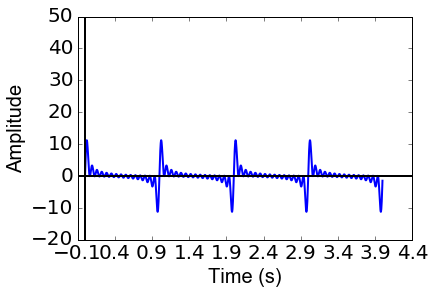

In [121]:
# Plot
plt.plot(t, sig, 'b-', linewidth = 2)    # specify x,y data...in this case time and amplitude of sin

# put some labels on the axes
plt.xlabel('Time (s)', **fig_font)
plt.ylabel('Amplitude', **fig_font)

# set the tick marks
plt.xticks(np.arange(-.1,tmax+.5,.5), color='k', size=20)
plt.yticks(np.linspace(-20,50,8), color='k', size=20)

# add some nice vertical/horizontal lines 
plt.axvline(0, color = 'k', linewidth = 2)
plt.axhline(0, color = 'k', linewidth = 2)

# show it
plt.show()

## Now FFT and lets have a look at the frequency spectrum 

In [122]:
sp = np.fft.rfft(sig)      # rfft = fft for real valued inputs\
# remember our coordinate system that we talked about earlier...this is the distance from the origin
amp = np.abs(sp)  

# normalize by the number of data points, 
# x2 cause we're ditching the negative frequencies when we deal with real numbers
amp = (amp  / len(sig) ) * 2   

# figure out the frequency resolution of the data 
freq = np.fft.rfftfreq(sig.size, dt)   # Sample spacing is 2nd arg, inverse of the sampling rate. Defaults to 1!

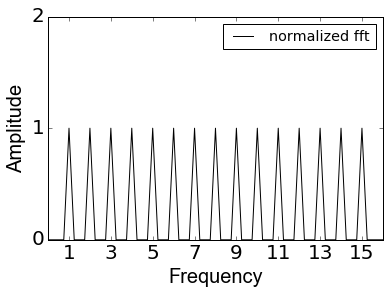

In [124]:
# plot the fft
plt.plot(freq, amp, 'k')            # plot amplitude 

# put a legend on it...
plt.legend(['normalized fft'], loc='best', fontsize='x-large')  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)

# set the axis limits
plt.xlim([0, Hf])

# show it
plt.show()

## Now design the perfect low pass filter - one that only passes frequencies below the cutoff and truncates everything else!
* Note that this will look like a box-car function in the frequency domain

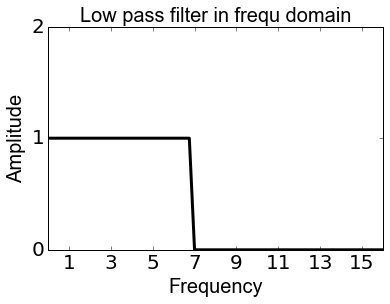

In [147]:
# lets pass everything blow 7Hz and cut off everything else
lowpass_cut = 7

# find the freq in our FFT range that is closest to our desired cutoff point
cutoff_pnt = np.argmin(np.abs(freq-lowpass_cut))

# make the filter
lp_filt = np.zeros(len(freq))
lp_filt[0:cutoff_pnt] = 1

plt.plot(freq, lp_filt, c='k', linewidth=3)
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.xticks(frequs[::2], color='k', size=20)
plt.yticks((0,1,2), color='k', size=20)
# set the axis limits
plt.xlim([0, Hf])
plt.title('Low pass filter in frequ domain', **fig_font)
plt.show()

In [8]:
fc = 0.01
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

# s = list(data['10 Min Std Dev'])
# new_signal = np.convolve(s, sinc_func)

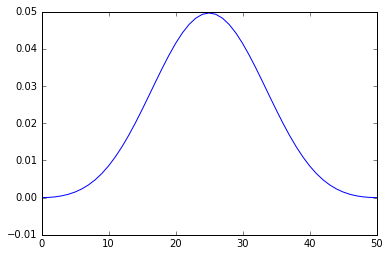

In [9]:
plt.plot(sinc_func)